_Laboratory 0_

# Exploring HRD, MIST & RAW DATA

    The amount of available high-precision astrometry and photometry has grown rapidly over the last years. The Gaia Data Release 2 (DR2) provides such data for about 1.3 billion sources over the full sky, with an unprecedented accuracy. The intention of this report is to illustrate how data from the Gaia DR2 can be acquired, cleansed and used to study the fine structures of Hertzsprung-Russell diagrams (HRD). By the use of simple filtration methods I aim to provide clear HRD for the open clusters Hyades and M67, as well as the globular cluster NGC6397. The filtering methods is based upon selecting members of each cluster based on their established parallax- and proper motion values. I will also apply the MIST models to over-plot the HRDs with synthetic photometry in Gaia bands for theoretical isochrones, and look at the various phases of stellar evolution in each cluster. 


# 2. General outline of method

   The main issue in getting from the query to a cluster HRD is removing all bodies that are in the same region of the sky but not physically associated with the cluster. For obtaining the data that just contains cluster members, to types of filtering is done. The first is applied directly in the ADQL query to the Gaia database. In the query there is applied restrictions and demands for the upper limit for errors in the data, adapted to the distance of the cluster. Looser restrictions is often necessary for the clusters that are relatively far away. The query also contains restrictions on the positioning of the cluster. I will alter the maximal allowed parallax filter for the cluster, but the rest of the filters I leave as recommended by Babusiaux et al, 2018a [1]. In all three cases a positioning cut is made by assuming the clusters center, and making a sphere around the coordinates with a radius R. The members of the cluster is all assumed to be located within this sphere.
   
   The second technique is applied to the data acquired by the query and the positional/quality restrictions. By looking at the distribution of the parallaxes and proper motions in the dataset, alongside the assumed known values for the cluster, one can filter out objects that are clearly not a part of the cluster. That is, clusters who's parallaxes are very different from the nominal cluster values or approaches zero as the distance to the object increases from the observational point. Also, it is clearly beneficial to look at the proper motions of the clusters as elements that behaves very different in the proper motion phase space or is far away from the assumed cluster values are unlikely to be a member. 
   
   Since the clusters at hand are of a different type from each other I vary how i approach the three cases. The individual approaches are closer explained under each clusters separate section. The technique applied is always iterative, and the general method and filtering techniques remain the same, different choices are made regarding the order of the filtering as well as what filter to apply in different cases. Especially, the globular cluster NGC6397 has to be treated differently from the two other open clusters.

# 3. The clusters

The clusters revived and analyzed in this report is Hyades, M67 and NGC6397. Table 1 presents the relevant astrometry data for the three clusters.


**Properties** | **Hyades** |  **M67**| **NGC 6397**
--- | --- | ---|  --- 
**Dec** | 15.86667 | 11.8| -53.674333 
**Ra** | 66.725| 132.825| 265.175375  
**Parallax** [Mas]|  21.052 | 1.1325| 0.3781
**PMRA** [Mas]/yr | 101.005 | -10.9737| 3.2908 [2]
**PMDEC** [Mas/yr] | -28.490 | -2.9396| -17.5908  [2]
**Age** [log(age] | 8.9 | 9.54| 10.13 
**Distance** [pc]| 47 | 800-900 | 2400
**[FE/H]** | 0.13 | 0.03 | -2.02
**Members** | 480 | 1194 | 10055

**Table 1**: The values for Hyades and M67 is acquired from [1], and the data for NGC6397 are acquired from [1] and [2] (where denoted).

        [1]: Gaia Collaboration, Babusiaux, C., van Leeuwen, F., et al. 2018a, A&A 
        [2]: Gaia Collaboration, Helmi, A., van Leeuwen, F., et al. 2018c, A&A

## Imports, general settings and fixed variabels

The following piece of code imports all necessary packages and modules, fixes the plotting style for the following plots as well as storing cluster variables gathered from [1] and [2]. 

In [1]:
# Necessary imports
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')



# General Plot Layout Parameters
matplotlib.rcParams['figure.figsize']  = (10.0, 5.0)
matplotlib.rcParams['axes.grid']       =True
matplotlib.rcParams['font.size']       = 12
matplotlib.rcParams['font.family']     = 'OfficinaSanITCBoo'
matplotlib.rcParams['axes.labelsize']  = 1.1*plt.rcParams['font.size']
matplotlib.rcParams['axes.titlesize']  = 1.1*plt.rcParams['font.size']
matplotlib.rcParams['legend.fontsize'] = plt.rcParams['font.size']
matplotlib.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
matplotlib.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
matplotlib.rcParams['scatter.marker']  = '.'


# Cluster parameters & Variables
Hyades_parallax  = 21.052           # [Mas]
Hyades_pmra      = 101.005          # [Mas/yr]
Hyades_pmdec     = -28.490          # [Mas/yr]
Hyades_dec       = 15.86667         # ['ICRS']
Hyades_ra        = 66.725           # ['ICRS']

M67_parallax     = 1.1325           # [Mas]
M67_pmra         = -10.9737         # [Mas/yr]
M67_pmdec        = -2.9396          # [Mas/yr]
M67_dec          = 11.8             # ['ICRS']
M67_ra           = 132.825          # ['ICRS']

NGC6397_parallax = 0.3781           # [Mas]
NGC6397_pmra     = 3.2908           # [Mas/yr]
NGC6397_pmdec    = -17.5908         # [Mas/yr]
NGC6397_dec      = -53.674333       # ['ICRS']
NGC6397_ra       = 265.175375       # ['ICRS']


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# 3.1 Hyades

Hyades is a young, nearby cluster. Because of the relatively short distance to the cluster the parallax is a good place to start searching for cluster members. Assuming that a _parallax_over_error_ > 10 will filter out most of the background stars, the query is submitted with a radius of 5 degrees from the center given in table 1. The first assumption can easily be tested by turning down the _parallax_over_error_, and check if this alter the final results. The radius-estimate can be calculated by looking at the distance to the cluster and the radius of the cluster found in literature. 

I have then assumed that all the cluster is located somewhere within this sphere centered in the assumed center of the cluster. To further examine the available data from this region, I plot the unfiltered data in the proper motion space (pmra vs. pmdec), the distributions of pmra, pmdec and the parallax of the cluster in histograms.

The proper motion space shows tendencies to cluster around the literature values for Hyades center, but it seems a bit uncertain that this is a cluster due to the few members and the location close too a bigger group of objects. By looking at the distributions in the histogram it is more evident that there are peaks around the literature values for both the parallax and the proper motion in right ascension. The data for the proper motion in declination is ambiguous. Therefore one should start with one of the two former histograms. I choose to begin the iterative filtering process by looking at the parallax, since one can expect that the parallax data from Gaia is trustworthy for such a close cluster with low parallax errors. 

I then take a closer look at the parallax histogram, and seclude an area around the literature value for Hyades parallax. I filter anything outside of a 20% of the expected value away, and this in effect filters away the objects that are likely to be in the background of the cluster (low parallax and parallax approaching zero) and the objects with to high of a parallax to reasonably assume that they are a cluster member.

I then move on to look at the effect this has on the pmra values, and the parallax-filter has clearly filtered away the biggest deviations from the pmdec values. I then apply the same kind of filter as for the parallax to the pmra with a margin of 20% once again, as seem reasonable by an eye estimation. This removes all outlying objects clearly deviating from the expected literature.

Even though there was no peak in the pmdec in the unfiltered data, I take a look at it once again after the parallax and pmra filters. The majority of the objects have been filtered out, but there still is no obvious way to set a margin for filtering the pmdec. Just to make sure that the absolute outermost objects are filtered, i apply a 80% margin threshold to remove apparent deviation.

After the three filters are applied I plot the filtered proper motion space, ra vs dec and the resulting HRD. I finish up by overlaying a synthetic isochrone generated by a [MIST](http://waps.cfa.harvard.edu/MIST/interp_isos.html) model. I use a synthetic photometry filter [UBV(RI)c + 2MASS + Kepler + Hippacoros + Gaia](http://waps.cfa.harvard.edu/MIST/interp_isos.html). The logarithm of the age and the Fe/H relation are applied as given in table 1. The extinction value is put to zero. 


### 3.1.1 ADQL Query sent to Gaia

In [2]:
# ADQL Query
job = Gaia.launch_job_async("SELECT pmra, pmdec ,parallax ,ra, dec, source_id, phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 10 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND CONTAINS(POINT('ICRS', gaiadr2.gaia_source.ra, gaiadr2.gaia_source.dec),CIRCLE('ICRS', 66.725,15.86667, 5))=1  ;" \
, dump_to_file=True)

print(job)
# Storing data to Pandas object
Hyd_Data = job.get_results().to_pandas()

print('-----------------------------------')
print('Initial amount of stars in cluster:')
print(len(Hyd_Data['mg']))

Jobid: 1549322167695O
Phase: COMPLETED
Owner: None
Output file: async_20190204151607.vot
Results: None
-----------------------------------
Initial amount of stars in cluster:
57454


### 3.1.2 Initial unfiltered data

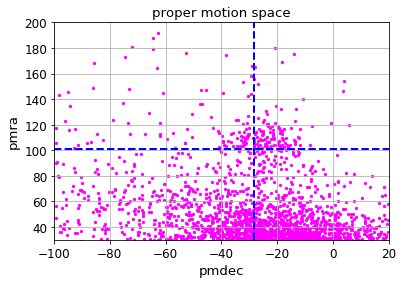

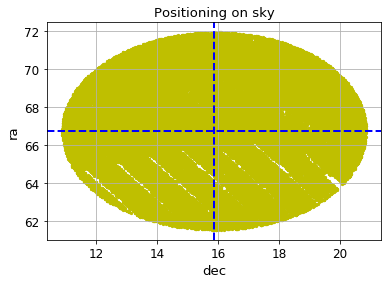

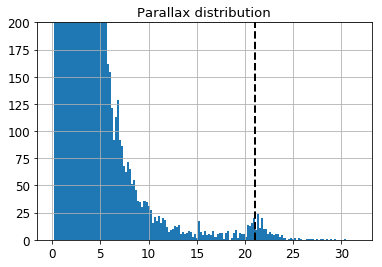

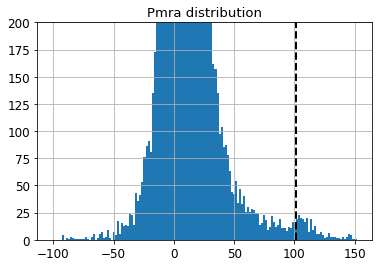

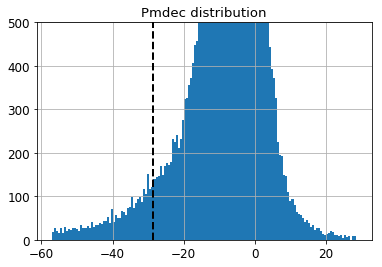

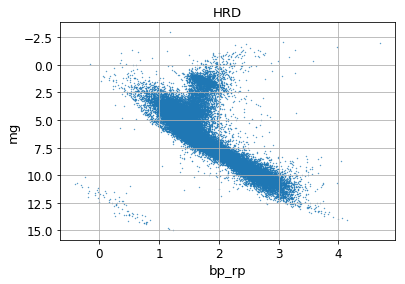

In [3]:
# Proper motion space
Hyd_Data.plot.scatter('pmdec','pmra',color = 'magenta')
plt.axvline(Hyades_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(Hyades_pmra, color='b', linestyle='dashed', linewidth=2)
plt.title('proper motion space')
plt.xlim(-100,20)
plt.ylim(30,200)

# Data represented in assumed sphere around the cluster
Hyd_Data.plot.scatter('dec','ra', color = 'y')
plt.title('Positioning on sky')
plt.axvline(Hyades_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(Hyades_ra, color='b', linestyle='dashed', linewidth=2)

# Distributions of Parallax, pmra and pmdec
Hyd_Data.hist(column = "parallax", bins = 150, range=(0, Hyades_parallax*1.5))
plt.title('Parallax distribution')
plt.axvline(Hyades_parallax, color='k', linestyle='dashed', linewidth=2)
plt.ylim(0, 200)


Hyd_Data.hist(column = "pmra", bins = 150, range=(-Hyades_pmra, 1.5*Hyades_pmra ))
plt.title('Pmra distribution')
plt.axvline(Hyades_pmra, color='k', linestyle='dashed', linewidth=2)
plt.ylim(0, 200)

Hyd_Data.hist(column = "pmdec", bins = 150, range=(2*Hyades_pmdec, -Hyades_pmdec ))
plt.title('Pmdec distribution')
plt.axvline(Hyades_pmdec, color='k', linestyle='dashed', linewidth=2)
plt.ylim(0, 500)


# HRD before filtering
Hyd_Data.plot.scatter('bp_rp','mg', s = 0.5)
plt.title('HRD')
plt.gca().invert_yaxis()


### 3.1.3 Parallax Filter

Current amount of stars in cluster, after parallax filter:
265


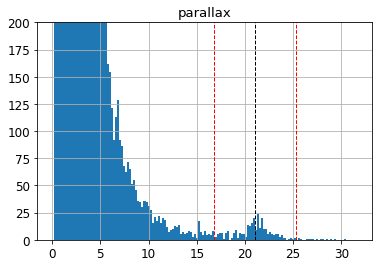

In [4]:
# Parallax filter
# Hist of parallax
Hyd_Data.hist(column = "parallax", bins = 150, range=(0, Hyades_parallax*1.5))
plt.axvline(Hyades_parallax, color='k', linestyle='dashed', linewidth=1)
plt.axvline(.8*Hyades_parallax, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.2*Hyades_parallax, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 200)

# Filter of parallax
Hyd_par_filter = Hyd_Data[(Hyd_Data['parallax'] < Hyades_parallax +.2*Hyades_parallax) 
                          &(Hyd_Data['parallax'] > Hyades_parallax -.2*Hyades_parallax) ]


print('Current amount of stars in cluster, after parallax filter:')
print(len(Hyd_par_filter['mg']))

### 3.1.4 PMRA Filter

Current amount of stars in cluster, after pmra filter:
188


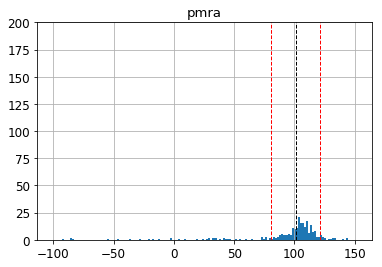

In [5]:
# Proper motion filers 1, pmra
# Hist of pmra
Hyd_par_filter.hist(column = "pmra", bins = 150, range=(-Hyades_pmra, 1.5*Hyades_pmra ))
plt.axvline(.8*Hyades_pmra, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.2*Hyades_pmra, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 200)
plt.axvline(Hyades_pmra, color='k', linestyle='dashed', linewidth=1)

# Filter of pmra
Hyd_pmra_filter = Hyd_par_filter[(Hyd_par_filter['pmra'] < Hyades_pmra+.2*Hyades_pmra) & 
                                 (Hyd_par_filter['pmra'] > Hyades_pmra-.2*Hyades_pmra)]

print('Current amount of stars in cluster, after pmra filter:')
print(len(Hyd_pmra_filter['mg']))

###  3.1.5 PMDEC Filter

Final amount of stars in cluster, after pmdec filter applied:
179


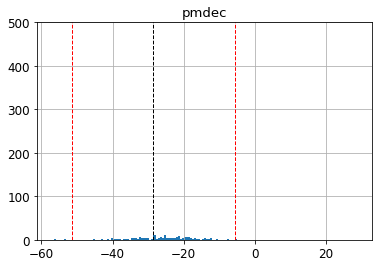

In [6]:
# Proper motion filter 2, pmdec
# Hist of pmdec
Hyd_pmra_filter.hist(column = "pmdec", bins = 150, range=(2*Hyades_pmdec, -Hyades_pmdec ))
plt.ylim(0, 500)
plt.axvline(.2*Hyades_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.8*Hyades_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.axvline(Hyades_pmdec, color='k', linestyle='dashed', linewidth=1)

# Filter of pmdec
Hyd_pmdec_filter = Hyd_pmra_filter[(Hyd_pmra_filter['pmdec'] > Hyades_pmdec+.8* Hyades_pmdec) 
                                   & (Hyd_pmra_filter['pmdec'] < Hyades_pmdec-.8*Hyades_pmdec)]


print('Final amount of stars in cluster, after pmdec filter applied:')
print(len(Hyd_pmdec_filter['mg']))


### 3.1.6 Hyades data after filtering

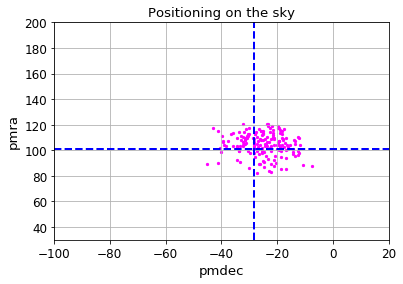

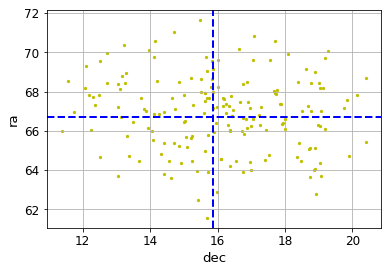

In [7]:
# Proper motion space
Hyd_pmdec_filter.plot.scatter('pmdec','pmra',color = 'magenta')
plt.title('Proper motion space')
plt.axvline(Hyades_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(Hyades_pmra, color='b', linestyle='dashed', linewidth=2)
plt.xlim(-100,20)
plt.ylim(30,200)

# Data represented in assumed sphere around the cluster
plt.title('Positioning on the sky')
Hyd_pmdec_filter.plot.scatter('dec','ra', color = 'y')
plt.axvline(Hyades_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(Hyades_ra, color='b', linestyle='dashed', linewidth=2)


(15, -5)

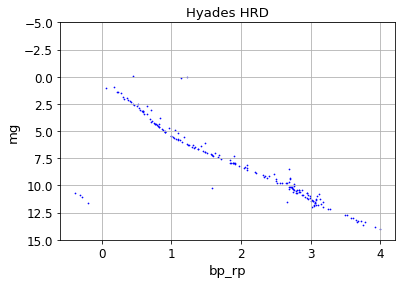

In [8]:
Hyd_pmra_filter.plot(kind='scatter', x='bp_rp', y='mg', color='b', s = 2) 
#plt.legend(['Synthetic Isochrone', 'Filtered cluster members'])
plt.title('Hyades HRD')
#plt.xlim(0,4)
plt.ylim(15,-5)

(15, -5)

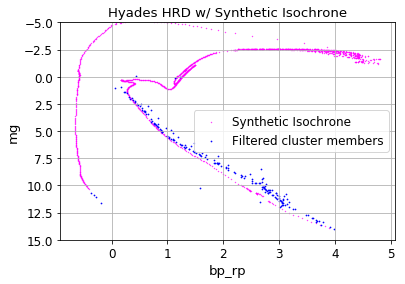

In [9]:
data = np.loadtxt("Hyades_iso.cmd", skiprows = 13, usecols = (22,23,24))
data = pd.DataFrame(data)
data = data.rename(columns={0: 'Mag', 1:'Gaia_BP_DR2Rev',2:'Gaia_RP_DR2Rev'})
data['bp_rp_iso'] = data['Gaia_BP_DR2Rev'] - data['Gaia_RP_DR2Rev']


ax1 = data.plot(kind='scatter', x='bp_rp_iso', y='Mag', color='magenta', s = 0.5)    
ax2 = Hyd_pmra_filter.plot(kind='scatter', x='bp_rp', y='mg', color='b', ax=ax1, s = 2) 
plt.legend(['Synthetic Isochrone', 'Filtered cluster members'])
plt.title('Hyades HRD w/ Synthetic Isochrone')
#plt.xlim(-1,4)
plt.ylim(15,-5)

# 3.2 M67

Messier 67 (M67) is also an open cluster, but more distant than Hyades. It is hear reasonable to assume that the threshold for the parallax error should be a bit lower, even though it is not obvious by how much. I try to place a filter of __parallax_over_error__ < 8, and assume a radius of 1 degree in the Gaia query. 

The set of data that the query provides deviates form the unfiltered Hyades data by certain interesting factors. Amongst other things the proper motion space is not clear at all, but we can on the other hand see tendency of more clustering in the center of the cluster just by looking at the position space. Some of the tendencies in the distribution is far more clear than for the Hyades. The most evident factor being the bright peak around the literature value for the proper motion in right ascension. Thus pmra becomes an obvious place to start the iteration filtering process. By eye estimation it seems reasonable to put a margin on 10% off the literature value, as this closes nicely around the peak. 

It is no obvious choice whether to progress with the parallax filter or the pmdec filter next. Although the pmdec distribution by eye seems to have a sharper peak, and as the tendency is not so strong for the lower parallax values, I choose to iterate over the pmdec next. In the case of pmdec it seems reasonable to place a 15% margin to fully enclose the peak. 

Moving on to the parallax filter, the peak is more evident now than initially and it is easier to approach by eye and expectations. I here assume a 10% filter to fully enclose the peak for the M67 parallax value. 

I then plot the filtered HRD and the filtered proper motions and positions. One can clearly see a reduction in the amount of objects, and the clustering tendencies is more evident especially in the position plot. I then apply the synthetic isochrone with an extinction value = 0 and the literature values for Fe/h and age. Seeing that this does not fit the filtered data especially well, i also plot an isochrone where i have turned up the extinction value = 0.2.

In [10]:
job = Gaia.launch_job_async("SELECT pmra, pmdec ,parallax ,ra, dec, source_id, phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 8 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND CONTAINS(POINT('ICRS', gaiadr2.gaia_source.ra, gaiadr2.gaia_source.dec),CIRCLE('ICRS', 132.825,11.8, 1))=1  ;" \
, dump_to_file=True)

print(job)
M67_Data = job.get_results().to_pandas()


print('-----------------------------------')
print('Initial amount of stars in cluster:')
print(len(M67_Data['mg']))

Jobid: 1549322262255O
Phase: COMPLETED
Owner: None
Output file: async_20190204151742.vot
Results: None
-----------------------------------
Initial amount of stars in cluster:
4001


### 3.2.1 Initial unfiltered data

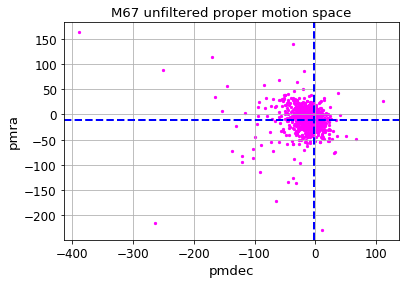

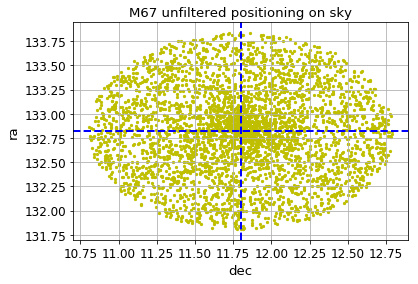

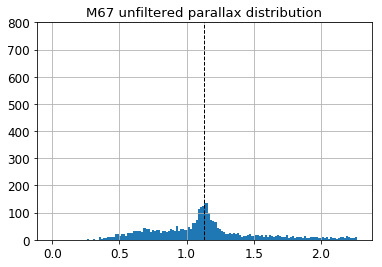

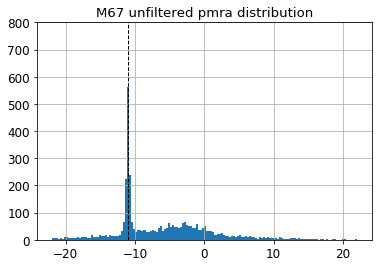

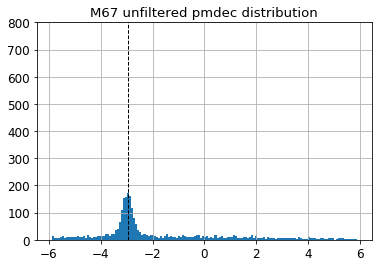

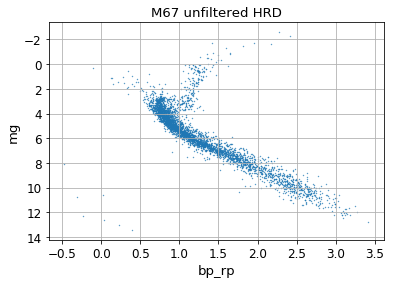

In [11]:
# Proper motion space
M67_Data.plot.scatter('pmdec','pmra',color = 'magenta')
plt.axvline(M67_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_pmra, color='b', linestyle='dashed', linewidth=2)
plt.title('M67 unfiltered proper motion space')
#plt.xlim(-100,100)
#plt.ylim(-100,100)

# Data represented in assumed sphere around the cluster
M67_Data.plot.scatter('dec','ra', color = 'y')
plt.title('M67 unfiltered positioning on sky')
plt.axvline(M67_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_ra, color='b', linestyle='dashed', linewidth=2)

# Distributions of Parallax, pmra and pmdec
M67_Data.hist(column = "parallax", bins = 150, range=(0, M67_parallax*2))
plt.title('M67 unfiltered parallax distribution')
plt.axvline(M67_parallax, color='k', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)


M67_Data.hist(column = "pmra", bins = 150, range=(M67_pmra*2,-M67_pmra*2))
plt.title('M67 unfiltered pmra distribution')
plt.axvline(M67_pmra, color='k', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

M67_Data.hist(column = "pmdec", bins = 150, range=(M67_pmdec*2,-M67_pmdec*2))
plt.title('M67 unfiltered pmdec distribution')
plt.axvline(M67_pmdec, color='k', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)



# HRD before filtering
M67_Data.plot.scatter('bp_rp','mg', s = 0.5)
plt.title('M67 unfiltered HRD')
plt.gca().invert_yaxis()


### 3.2.2 PMRA Filter

Current amount of stars in cluster, after pmra filter:
1236


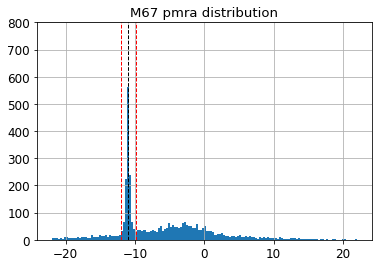

In [12]:
# Proper motion filers 1, pmra
# Hist of pmra
M67_Data.hist(column = "pmra", bins = 150, range=(M67_pmra*2,-M67_pmra*2))
plt.axvline(M67_pmra, color='k', linestyle='dashed', linewidth=1)
plt.title('M67 pmra distribution')
plt.axvline(.9* M67_pmra, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.1* M67_pmra, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

# Filter of parallax
M67_pmra_filter = M67_Data[(M67_Data['pmra'] > M67_pmra +.1*M67_pmra) 
                          &(M67_Data['pmra'] < M67_pmra -.1*M67_pmra) ]


print('Current amount of stars in cluster, after pmra filter:')
print(len(M67_pmra_filter['mg']))

### 3.2.3 PMDEC Filter

Current amount of stars in cluster, after pmdec filter:
991


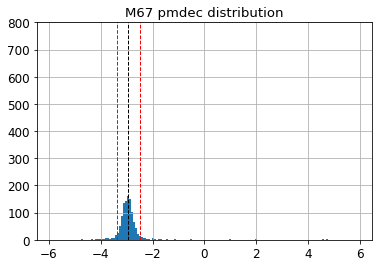

In [13]:
# Proper motion filers 1, pmdec
# Hist of pmra
M67_pmra_filter.hist(column = "pmdec", bins = 150, range=(M67_pmdec*2,-M67_pmdec*2))
plt.title('M67 pmdec distribution')
plt.axvline(M67_pmdec, color='k', linestyle='dashed', linewidth=1)
plt.axvline(.85* M67_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.15* M67_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

# Filter of pmdec
M67_pmdec_filter = M67_pmra_filter[(M67_pmra_filter['pmdec'] > M67_pmdec +.15*M67_pmdec) 
                          &(M67_pmra_filter['pmdec'] < M67_pmdec -.15*M67_pmdec) ]


print('Current amount of stars in cluster, after pmdec filter:')
print(len(M67_pmdec_filter['mg']))

### 3.2.4 Parallax Filter

Final amount of stars in cluster, after parallax filter:
860


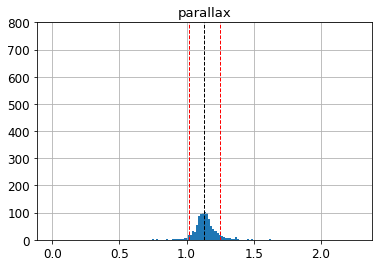

In [14]:
# Parallax filter
# Hist of parallax
M67_pmdec_filter.hist(column = "parallax", bins = 150, range=(0, M67_parallax*2))
plt.axvline(M67_parallax, color='k', linestyle='dashed', linewidth=1)
plt.axvline(.9*M67_parallax, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.1*M67_parallax, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

# Filter of parallax
M67_par_filter = M67_pmdec_filter[(M67_Data['parallax'] < M67_parallax +.1*M67_parallax) 
                          &(M67_Data['parallax'] > M67_parallax -.1*M67_parallax) ]


print('Final amount of stars in cluster, after parallax filter:')
print(len(M67_par_filter['mg']))

### 3.2.5 M67 Data after filtering

#### After application of pmra & pmdec

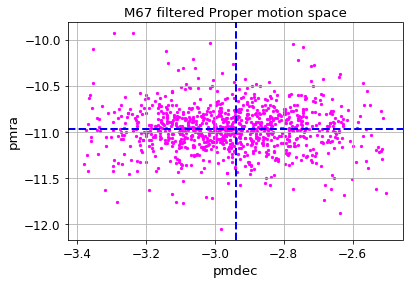

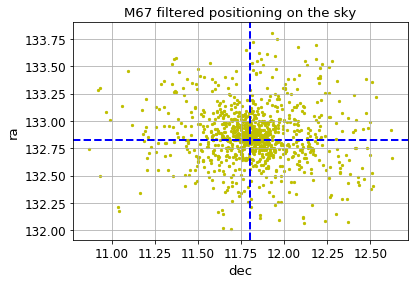

In [15]:
# Proper motion space
M67_pmdec_filter.plot.scatter('pmdec','pmra',color = 'magenta')
plt.title('M67 filtered Proper motion space')
plt.axvline(M67_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_pmra, color='b', linestyle='dashed', linewidth=2)

# Data represented in assumed sphere around the cluster
M67_pmdec_filter.plot.scatter('dec','ra', color = 'y')
plt.title('M67 filtered positioning on the sky')
plt.axvline(M67_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_ra, color='b', linestyle='dashed', linewidth=2)

#### After application of all filters

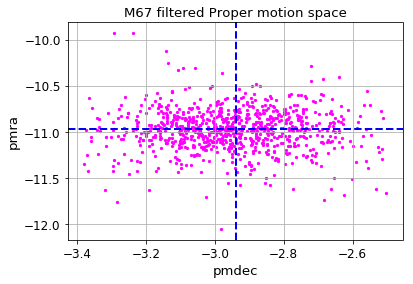

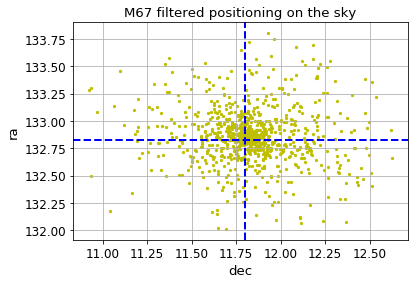

In [16]:
# Proper motion space
M67_par_filter.plot.scatter('pmdec','pmra',color = 'magenta')
plt.title('M67 filtered Proper motion space')
plt.axvline(M67_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_pmra, color='b', linestyle='dashed', linewidth=2)

# Data represented in assumed sphere around the cluster
M67_par_filter.plot.scatter('dec','ra', color = 'y')
plt.title('M67 filtered positioning on the sky')
plt.axvline(M67_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(M67_ra, color='b', linestyle='dashed', linewidth=2)


### 3.2.6 HRD & Synthetic Isochrone

(10, -2)

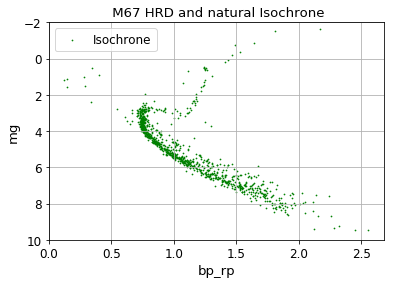

In [17]:
   
M67_pmdec_filter.plot(kind='scatter', x='bp_rp', y='mg', color='g', s = 2) 
plt.title(' M67 HRD and natural Isochrone')
plt.legend(['Isochrone','Filtered data'])
#plt.xlim(0.5,2)
plt.ylim(10,-2)

(8, 2)

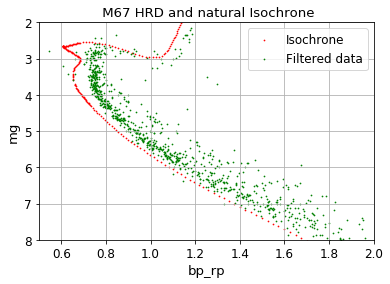

In [18]:
data = np.loadtxt("M67_iso.cmd", skiprows = 13, usecols = (22,23,24))
data = pd.DataFrame(data)
data = data.rename(columns={0: 'Mag', 1: 'Gaia_BP_DR2Rev',2:'Gaia_RP_DR2Rev'})
data['bp_rp_iso'] = data['Gaia_BP_DR2Rev'] - data['Gaia_RP_DR2Rev']

ax1 = data.plot(kind='scatter', x='bp_rp_iso', y='Mag', color='r', s = 2)    
ax2 = M67_pmdec_filter.plot(kind='scatter', x='bp_rp', y='mg', color='g', ax=ax1, s = 2) 
plt.title(' M67 HRD and natural Isochrone')
plt.legend(['Isochrone','Filtered data'])
plt.xlim(0.5,2)
plt.ylim(8,2)

(8, 2)

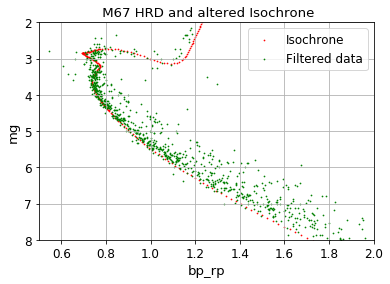

In [19]:
data = np.loadtxt("M67_iso4.cmd", skiprows = 13, usecols = (22,23,24))
data = pd.DataFrame(data)
data = data.rename(columns={0: 'Mag', 1: 'Gaia_BP_DR2Rev',2:'Gaia_RP_DR2Rev'})
data['bp_rp_iso'] = data['Gaia_BP_DR2Rev'] - data['Gaia_RP_DR2Rev']

ax1 = data.plot(kind='scatter', x='bp_rp_iso', y='Mag', color='r', s = 2)    
ax2 = M67_pmdec_filter.plot(kind='scatter', x='bp_rp', y='mg', color='g', ax=ax1, s = 2) 
plt.title(' M67 HRD and altered Isochrone')
plt.legend(['Isochrone','Filtered data'])
plt.xlim(0.5,2)
plt.ylim(8,2)

# 3.3 NGC  6397


NGC6397 is a globular, even more distant cluster. For such a cluster we can not expcect the parallax to give any reasonable information. This is illustrated in the unfiltered parallax histogram. Also it seems reasonable to expect that the general error in the parallax data should be greater. Therefore I start by increasing the limit for the maximum parallax error so that __parallax_over_error__ > 2. Also here I set the radius to 1 degree in the query. 

When taking a look at the unfiltered data the only place it looks reasonable to start is with the proper motion in declination. I apply a margin of 10%. 

Then I move on to look at the effect this filter has on the pmra, and place a new margin of 40% around the peak of the nominal pmra value. 

There is not much to analyze of the NGC6397 parallax, but to filter out any star who's parallax is 10 times bigger or more than the NGC6397 I place a tiny filter who reduces the amount of expected members by a little. 

I then plot the resulting filtered HRD with a synthetic isochrone according the to literature values of age and Fe/H with extinction value 0. This does not seem to match the filtered data at all. By trying to vary the parameters for both the age and extinction value, one can obtain a curve that fits the data better. For the altered isochrone i reduce the input logarithmic age to 9.9 and turn up the extinction value to 0.5. 

In [20]:
job = Gaia.launch_job_async("SELECT pmra, pmdec ,parallax ,ra, dec, source_id, phot_g_mean_mag+5*log10(parallax)-10 AS mg, bp_rp FROM gaiadr2.gaia_source \
WHERE parallax_over_error > 1 \
AND phot_g_mean_flux_over_error>50 \
AND phot_rp_mean_flux_over_error>20 \
AND phot_bp_mean_flux_over_error>20 \
AND phot_bp_rp_excess_factor < 1.3+0.06*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND phot_bp_rp_excess_factor > 1.0+0.015*power(phot_bp_mean_mag-phot_rp_mean_mag,2) \
AND visibility_periods_used>8 \
AND astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5))) \
AND CONTAINS(POINT('ICRS', gaiadr2.gaia_source.ra, gaiadr2.gaia_source.dec),CIRCLE('ICRS', 265.175375,-53.674333, 1))=1  ;" \
, dump_to_file=True)

print(job)
NGC6397_Data = job.get_results().to_pandas()
print('-------------------------------------------')
print('Initial amount of stars in NGC6397 cluster:')
print(len(NGC6397_Data['mg']))

Jobid: 1549322270471O
Phase: COMPLETED
Owner: None
Output file: async_20190204151750.vot
Results: None
-------------------------------------------
Initial amount of stars in NGC6397 cluster:
99444


### 3.3.1 NGC6397 unfiltered Data 6397

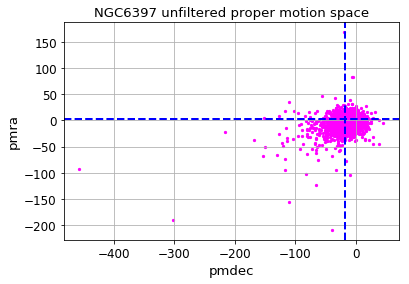

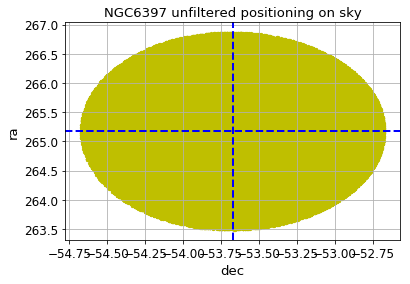

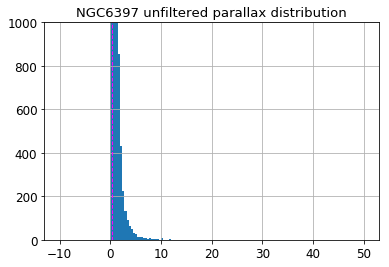

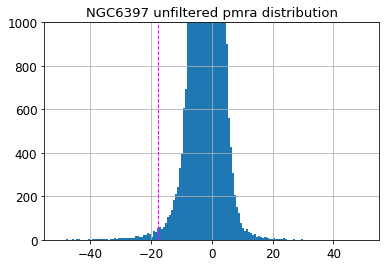

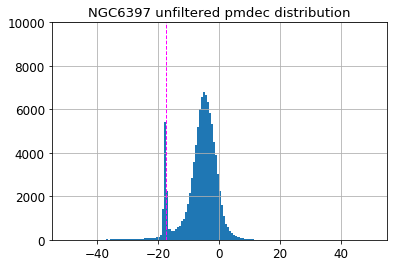

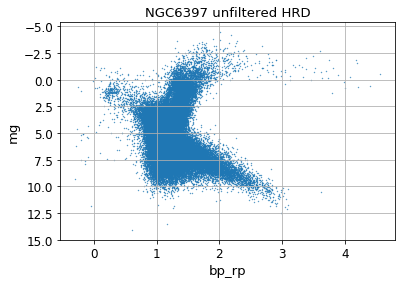

In [21]:
# Proper motion space
NGC6397_Data.plot.scatter('pmdec','pmra',color = 'magenta')
plt.axvline(NGC6397_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(NGC6397_pmra, color='b', linestyle='dashed', linewidth=2)
plt.title('NGC6397 unfiltered proper motion space')
#plt.xlim(-50,50)
#plt.ylim(-50,50)

# Data represented in assumed sphere around the cluster
NGC6397_Data.plot.scatter('dec','ra', color = 'y')
plt.title('NGC6397 unfiltered positioning on sky')
plt.axvline(NGC6397_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(NGC6397_ra, color='b', linestyle='dashed', linewidth=2)

# Distributions of Parallax, pmra and pmdec
NGC6397_Data.hist(column = "parallax", bins = 150, range=(-10, 50))
plt.title('NGC6397 unfiltered parallax distribution')
plt.axvline(NGC6397_parallax, color='magenta', linestyle='dashed', linewidth=1)
plt.ylim(0, 1000)

NGC6397_Data.hist(column = "pmra", bins = 150, range=(-50, 50))
plt.title('NGC6397 unfiltered pmra distribution')
plt.axvline(NGC6397_pmdec, color='magenta', linestyle='dashed', linewidth=1)
plt.ylim(0, 1000)

NGC6397_Data.hist(column = "pmdec", bins = 150, range=(-50, 50))
plt.title('NGC6397 unfiltered pmdec distribution')
plt.axvline(NGC6397_pmdec, color='magenta', linestyle='dashed', linewidth=1)
plt.ylim(0, 10000)

# HRD before filtering
NGC6397_Data.plot.scatter('bp_rp','mg', s = 0.5)
plt.title('NGC6397 unfiltered HRD')
plt.gca().invert_yaxis()

### 3.3.2 PMDEC Filter

Current amount of stars in cluster, after pmdec filter:
9862


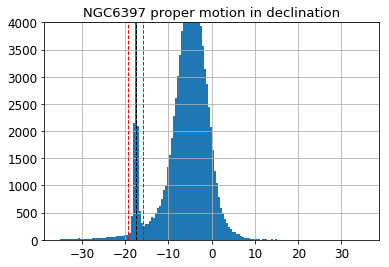

In [22]:
# Pmdec Filter

# Proper motion filers 1, pmdec
# Hist of pmra
NGC6397_Data.hist(column = "pmdec", bins = 150, range=(NGC6397_pmdec*2,-NGC6397_pmdec*2))
plt.title("NGC6397 proper motion in declination")
plt.axvline(NGC6397_pmdec, color='k', linestyle='dashed', linewidth=1)
plt.axvline(.9* NGC6397_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.1* NGC6397_pmdec, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 4000)

# Filter of parallax
NGC6397_pmdec_filter = NGC6397_Data[( NGC6397_Data['pmdec'] > NGC6397_pmdec +.1*NGC6397_pmdec) 
                          &( NGC6397_Data['pmdec'] < NGC6397_pmdec -.1*NGC6397_pmdec) ]


print('Current amount of stars in cluster, after pmdec filter:')
print(len(NGC6397_pmdec_filter['mg']))


### 3.3.3 PMRA Filter

Current amount of stars in cluster, after pmra filter:
8755


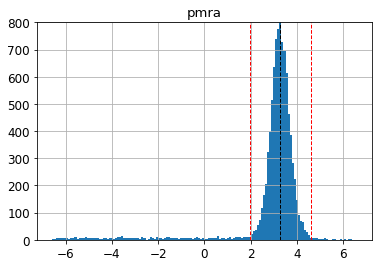

In [23]:
# Proper motion filers 1, pmra
# Hist of pmra
NGC6397_pmdec_filter.hist(column = "pmra", bins = 150, range=(-NGC6397_pmra*2,NGC6397_pmra*2))
plt.axvline(NGC6397_pmra, color='k', linestyle='dashed', linewidth=1)
plt.axvline(.6* NGC6397_pmra, color='r', linestyle='dashed', linewidth=1)
plt.axvline(1.4* NGC6397_pmra, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

# Filter of parallax
NGC6397_pmra_filter = NGC6397_pmdec_filter[(NGC6397_pmdec_filter['pmra'] < NGC6397_pmra +.4*NGC6397_pmra) 
                          &(NGC6397_pmdec_filter['pmra'] > NGC6397_pmra -.4*NGC6397_pmra) ]


print('Current amount of stars in cluster, after pmra filter:')
print(len(NGC6397_pmra_filter['mg']))

### 3.3.4 Parallax upper limit filter

Final amount of stars in cluster, after parallax filter:
7812


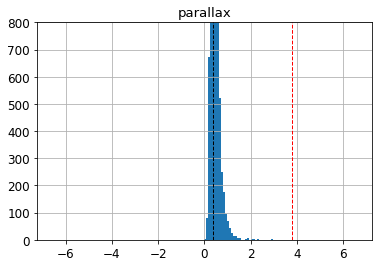

In [24]:
# Proper motion filers 1, pmra
# Hist of pmra
NGC6397_pmra_filter.hist(column = "parallax", bins = 150, range=(-NGC6397_pmra*2,NGC6397_pmra*2))
plt.axvline(NGC6397_parallax, color='k', linestyle='dashed', linewidth=1)
plt.axvline(10* NGC6397_parallax, color='r', linestyle='dashed', linewidth=1)
plt.ylim(0, 800)

# Filter of parallax
NGC6397_par_filter = NGC6397_pmra_filter[NGC6397_pmdec_filter['pmra'] < 10*NGC6397_parallax ]


print('Final amount of stars in cluster, after parallax filter:')
print(len(NGC6397_par_filter['mg']))

### 3.3.5 NGC 6397 Filtered Data

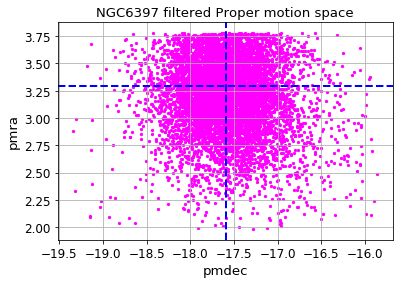

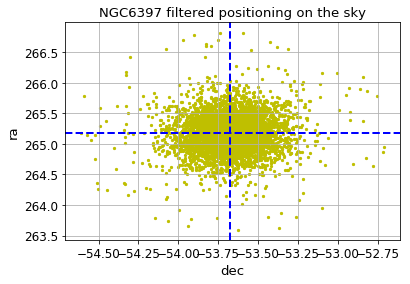

In [25]:
# Proper motion space
NGC6397_par_filter.plot.scatter('pmdec','pmra',color = 'magenta')
plt.title('NGC6397 filtered Proper motion space')
plt.axvline(NGC6397_pmdec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(NGC6397_pmra, color='b', linestyle='dashed', linewidth=2)

# Data represented in assumed sphere around the cluster
NGC6397_par_filter.plot.scatter('dec','ra', color = 'y')
plt.title('NGC6397 filtered positioning on the sky')
plt.axvline(NGC6397_dec, color='b', linestyle='dashed', linewidth=2)
plt.axhline(NGC6397_ra, color='b', linestyle='dashed', linewidth=2)

### 3.3.6 HRDs and Synthetic Isochrones

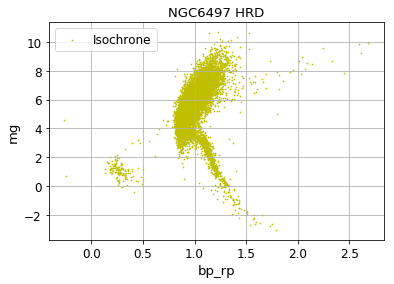

In [26]:
NGC6397_pmra_filter.plot(kind='scatter', x='bp_rp', y='mg', color='y', s = 2) 
plt.title('NGC6497 HRD')
plt.legend(['Isochrone','Filtered data'])

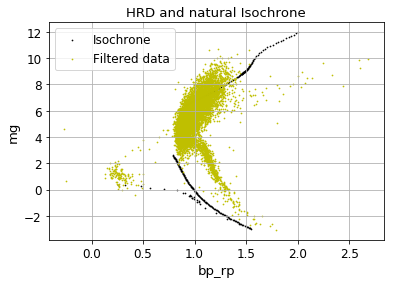

In [27]:
data = np.loadtxt("NGC6397_iso.cmd", skiprows = 13, usecols = (22,23,24))
data = pd.DataFrame(data)
data = data.rename(columns={0: 'Mag', 1:'Gaia_BP_DR2Rev',2:'Gaia_RP_DR2Rev'})
data['bp_rp_iso'] = data['Gaia_BP_DR2Rev'] - data['Gaia_RP_DR2Rev']


ax1 = data.plot(kind='scatter', x='bp_rp_iso', y='Mag', color='k', s = 2)    
ax2 = NGC6397_pmra_filter.plot(kind='scatter', x='bp_rp', y='mg', color='y', ax=ax1, s = 2) 
plt.title('HRD and natural Isochrone')
plt.legend(['Isochrone','Filtered data'])
#plt.xlim(0,2)
#plt.ylim(10,-2)

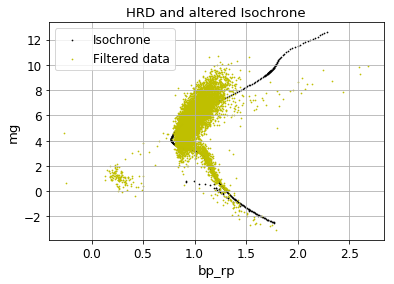

In [28]:
data = np.loadtxt("NGC8.cmd", skiprows = 13, usecols = (22,23,24))
data = pd.DataFrame(data)
data = data.rename(columns={0: 'Mag', 1:'Gaia_BP_DR2Rev',2:'Gaia_RP_DR2Rev'})
data['bp_rp_iso'] = data['Gaia_BP_DR2Rev'] - data['Gaia_RP_DR2Rev']


ax1 = data.plot(kind='scatter', x='bp_rp_iso', y='Mag', color='k', s = 2)    
ax2 = NGC6397_pmra_filter.plot(kind='scatter', x='bp_rp', y='mg', color='y', ax=ax1, s = 2) 
plt.title('HRD and altered Isochrone')
plt.legend(['Isochrone','Filtered data'])
#plt.xlim(0,2)
#plt.ylim(10,-2)

# 4. Discussion

Even though some reasonable data was obtained from the above filtering, one must assume that the uncertainties with this by eye approximations are big. 

The first big assumption is that the parallax error in the dataset is sufficiently small that the effect of lightly tuning does not significantly alter the final result. The effect this cut has on the data acquired from Gaia needs to be properly tested if the assumption holds, and even better locate the actual values that is relevant for a specific cluster. It is also reasonable to assume that the assumptions validity will vary by the type of cluster being treated. It was proved harder to find an appropriate threshold for the globular cluster than for Hyades for example, that did not alter the final result to much when varied. Also to make the query better adapted for the specific cluster one should look further into the other restrictions made in the WHERE clause of the ADQL. 

The second big assumption is that the radius choose for the sphere who encloses the cluster is the right one. This seems like a fair assumption, especially when the data for the radius of the cluster and the distance to it has an small error associated with it. Also, it looks reasonable from the results above that a sufficiently large radius or a radius of larger size does not affect the end results to much. This can be tested by systematically alter the radius and holding all other parameters fixed. The biggest risk with this assumption is probably that one can miss out on the outermost members of the cluster, witch one reasonably can assume does not constitute a significant amount. 

When it comes to applying the filters to the parallaxes and proper motions, some big uncertainties are also involved. Every estimation for the cuts is made by eye by looking at the distributions, and naturally has a high risk involved with human error. I've choose to overlook this fact during this work, as the goal was not to produce the most accurate and reasonable data, but to find a way to initially obtain and derive an HRD. To improve the technique above one has to find a better method for assuming the margins to the parameters passing through the filter. One way could possibly by to construct an algorithm to run over all the data from the possible members, find the maximum and minimum value, and place the margins there after. An alternate method may involve running through the data and finding the standard deviation. Perhaps a reasonable margin to set would be three or five times the standard deviation from the sampling set. 

One further momentum deserves notion, and that is the way the filters are applied to the data. For the globular cluster NGC6397 there did not seem to be much choice in the order the filters were applied in with this method. For the Hyades and M67 cluster on the other hand, alternate choices could have been made. For M68 it seems reasonable to alter the order of filtering the parallax and the pmdec, while starting off with the pmra filter still holds as reasonable. For the Hyades cluster starting off with the pmdec seems undeniably unreasonable, but one could alter the order of filtering the parallax and the pmra. One should also investigate what determines witch parameter witch is a reasonable start off, and why it is so, to better understand the data and the orders at hand.

So as indicated the actual numbers and analysis of the data carries big uncertainties, which most likely are sources to bad astrometry through this method. Nevertheless the method was not entirely unsuccessful, as it more or less accomplished it's intention: To provide a simple method for sending a query to gather the astrometry and photometry, and construct HRDs from the obtained data. Also it is very reasonable to assume the cuts made to the proper motions and parallax have removed a lot of suspect objects. For example objects that move entirely different from the general tendency of the cluster, or by looking at the parallax seems to exist in another general regions.

By looking at the diagnostics plot it is clear that the filter removes a lot of the suspicious objects to. For example it is especially evident when looking at the Hyades cluster, where the majority of the objects in phase space is not centered around the expected value for pmra and pmdec. The diagnostics plots illustrates how the majorities center is filtered away by applying the first parallax filter, and then the two last filters just fine tunes the selection as shown above. 

# 5. Conclusions 

Even though the data as postulated during the discussion is uncertain, the main goal of this report was not to acquire the most precise estimations for the amount of members, but to find an easy way to acquire and make an initial analysis. In that manner the method described above was successful. Further implementations and more refined cluster finding techniques must be implemented to abstract more precise data. The information that this analysis found is report below. 

## 5.1 Members detected

It is evident in all three of the clusters that the filtering method has removed the majority of the objects present in the data, and produced more refined HRDs. 

**Cluster** | **Membership derived** |  **Nominal membership**| **Percentage detected**
--- | --- | ---|  --- 
**Hyades** | 179|480| 37 %
**M67** |860 |1194| 72 %
**NGC** | 6278|10055| 62 %

**Table 2**: An overview of the number of members in the clusters derived from the filters, the literature values for the number of members in the cluster, the the percentage detected in whole.

## 5.2 HRD analysis

The HRD diagram here gives some suggestion to the various phases of stellar evolution present in each cluster and some indications of having a binary or higher order stars. The binary stars are indicated by having a small deviation from the main sequence with a smaller magnitude. 

In the Hyades cluster we find that most of the stars lays along the main sequence. Otherwise the HRD indicates about 4 stars in the with draw region and 2-3 stars wandering close the the giants-branch. This fits well knowing that Hyades is a relatively young cluster. About 10 points seem to have a larger magnitude than the one predicted by the isochrone and the general tendencies of the other objects. This indicates that Hyades has binary systems. 

The M67 cluster also have a majority of stars located along the main sequence, but it is also evident that a lot of the stars have started wandering towards the giants section with magnitudes around 0. A couple of stars approaches absolute magnitudes of around -2, and seems to be on the way to the super giant branch. This fits the fact that the M67 is as bit older, also seen relative to the Hyades cluster. There are also a lot of opportunities for binary stars presented by the HRD. Lot of the stars have relatively big absolute magnitudes around the main sequence, in relation to the majority. 

The NGC6397 is the oldest cluster, and seems to have the majority of its stars wandering and living on the giant and super giant branch. It also have a significant section of white dwarfs and some stars still along the main sequence. The tendency for binary stars seems big, but it's harder to read out as the main lines is not so clear for this globular cluster as for the two younger ones.

Finally, it should be mentioned that there are some big deviations from the theoretical expectations. It is hard to know exactly by how much, as the isochrones them selfs seems to be estimated a bit of grid. This might be because of a systematic error or a misunderstanding. If one compares the natural isochrones, I.e. the ones where the age and Fe/H is as in the literature, and the extinction value is left out, one sees deviation between how well each cluster fits with it's synthetic isochrone. I.e. The Hyades seems to fit it's Isochrone quite well for the main sequence, while the M67 cluster is a bit off grid but follows the same pattern. When regulated for in the extinction value it fits quite well. This is an indication that noise that should be accounted for is present in the data. The NGC6397 is the set that fits the worst with it's isochrone. The initial data does not seem to have much in common with the theoretical isochrone at all, expect sharing a few common tendencies in its evolution. This might be because of the neglect ion of taking the extinction in to account or another misunderstanding of the isochrones. Further analysis must be done to determine what the reason for this might be. 

# Abbreviations

Abbreviation | Long form
--- | ---  
Dec | Declination
ra |Right ascension
pmra | proper motion in right ascension
pmdec |proper motion in right declination
DR2 |Data release 2
